# IV and Panel IV
---

In [38]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
from linearmodels.iv import IV2SLS
from linearmodels.iv import IVGMM
from linearmodels import PooledOLS
from linearmodels import PanelOLS
from linearmodels.iv import compare

import matplotlib.pyplot as plt
import seaborn as sns

from linearmodels.datasets import card

sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(12,9)})

pd.set_option('display.max_rows', 100)

# 1. Instrumental Variables
---
- This example combines (with edits and comments by Christopher Lo):
    - Rachel Meager's EC333 Lent Term R code 
    - https://bashtage.github.io/linearmodels/doc/iv/examples/basic-examples.html 

In [2]:
# import data

college_data = card.load()
print(card.DESCR)


D. Card (1995), "Using Geographic Variation in College Proximity to Estimate
the Return to Schooling," in Aspects of Labour Market Behavior:  Essays in
Honour of John Vanderkamp.  Ed. L.N. Christophides, E.K. Grant, and R.
Swidinsky, 201-222.  Toronto: University of Toronto Press.

id                       person identifier
nearc2                   =1 if near 2 yr college, 1966
nearc4                   =1 if near 4 yr college, 1966
educ                     years of schooling, 1976
age                      in years
fatheduc                 father's schooling
motheduc                 mother's schooling
weight                   NLS sampling weight, 1976
momdad14                 =1 if live with mom, dad at 14
sinmom14                 =1 if with single mom at 14
step14                   =1 if with step parent at 14
reg661                   =1 for region 1, 1966
reg662                   =1 for region 2, 1966
reg663                   =1 for region 3, 1966
reg664                   =1 for regi

In [3]:
# Add a constant column

college_data = sm.add_constant(college_data)
college_data

,const,id,nearc2,nearc4,educ,age,fatheduc,motheduc,weight,momdad14,...,smsa66,wage,enroll,KWW,IQ,married,libcrd14,exper,lwage,expersq
0,1.0,2,0,0,7,29,NaN,NaN,158413,1,...,1,548,0,15.0,NaN,1.0,0.0,16,6.306275,256
1,1.0,3,0,0,12,27,8.0,8.0,380166,1,...,1,481,0,35.0,93.0,1.0,1.0,9,6.175867,81
2,1.0,4,0,0,12,34,14.0,12.0,367470,1,...,1,721,0,42.0,103.0,1.0,1.0,16,6.580639,256
3,1.0,5,1,1,11,27,11.0,12.0,380166,1,...,1,250,0,25.0,88.0,1.0,1.0,10,5.521461,100
4,1.0,6,1,1,12,34,8.0,7.0,367470,1,...,1,729,0,34.0,108.0,1.0,0.0,16,6.591674,256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3005,1.0,218,0,1,12,25,8.0,12.0,82135,1,...,0,335,0,15.0,NaN,1.0,0.0,7,5.814130,49
3006,1.0,219,0,1,13,34,NaN,NaN,88765,1,...,0,481,0,43.0,NaN,1.0,1.0,15,6.175867,225
3007,1.0,220,0,1,12,24,11.0,NaN,89271,0,...,0,500,0,25.0,109.0,1.0,0.0,6,6.214608,36
3008,1.0,221,0,1,12,31,NaN,NaN,110376,1,...,0,713,0,32.0,107.0,1.0,1.0,13,6.569481,169


In [4]:
# Seperate out variables

dep = ['wage']
endog = ['educ']
exog = ['const','exper','expersq','black','smsa','south','smsa66','reg662',
       'reg663','reg664','reg665','reg666','reg667','reg668','reg669']
instr = ['nearc4']

# Select relevant columns and drop rows with missing values

college_data = college_data[dep +exog+endog+ instr].dropna()
college_data

,wage,const,exper,expersq,black,smsa,south,smsa66,reg662,reg663,reg664,reg665,reg666,reg667,reg668,reg669,educ,nearc4
0,548,1.0,16,256,1,1,0,1,0,0,0,0,0,0,0,0,7,0
1,481,1.0,9,81,0,1,0,1,0,0,0,0,0,0,0,0,12,0
2,721,1.0,16,256,0,1,0,1,0,0,0,0,0,0,0,0,12,0
3,250,1.0,10,100,0,1,0,1,1,0,0,0,0,0,0,0,11,1
4,729,1.0,16,256,0,1,0,1,1,0,0,0,0,0,0,0,12,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3005,335,1.0,7,49,0,0,1,0,0,0,0,0,1,0,0,0,12,1
3006,481,1.0,15,225,0,1,1,0,0,0,0,0,1,0,0,0,13,1
3007,500,1.0,6,36,0,0,1,0,0,0,0,0,1,0,0,0,12,1
3008,713,1.0,13,169,0,0,1,0,0,0,0,0,1,0,0,0,12,1


# 1.1. Naive OLS Model

In [5]:
# Regress wages on education plus controls

reg_wages_education = sm.OLS(np.log(college_data[dep]), college_data[endog + exog]).fit()
reg_wages_education.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.300
Model:                            OLS   Adj. R-squared:                  0.296
Method:                 Least Squares   F-statistic:                     85.48
Date:                Fri, 02 Oct 2020   Prob (F-statistic):          1.74e-218
Time:                        17:36:42   Log-Likelihood:                -1288.8
No. Observations:                3010   AIC:                             2610.
Df Residuals:                    2994   BIC:                             2706.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
educ           0.0747      0.003     21.351      0.000       0.068       0.082
const          4.6208      0.074     62.248      0.000       4.475       4.766
exper          0.0848      0.007     12.806      0.000       0.072       0.098
expersq       -0.0023      0.000     -7.223      0.000      -0.003      -0.002
black         -0.1990      0.018    -10.906      0.000      -0.235      -0.163
smsa           0.1364      0.020      6.785      0.000       0.097       0.176
south         -0.1480      0.026     -5.695      0.000      -0.199      -0.097
smsa66         0.0262      0.019      1.349      0.177      -0.012       0.064
reg662         0.0964      0.036      2.684      0.007       0.026       0.167
reg663         0.1445      0.035      4.115      0.000       0.076       0.213
reg664         0.0551      0.042      1.322      0.186      -0.027       0.137
reg665         0.1280      0.042      3.060      0.002       0.046       0.210
reg666         0.1405      0.045      3.106      0.002       0.052       0.229
reg667         0.1180      0.045      2.633      0.008       0.030       0.206
reg668        -0.0564      0.051     -1.101      0.271      -0.157       0.044
reg669         0.1186      0.039      3.054      0.002       0.042       0.195
==============================================================================
Omnibus:                       59.717   Durbin-Watson:                   1.880
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               71.222
Skew:                          -0.282   Prob(JB):                     3.42e-16
Kurtosis:                       3.501   Cond. No.                     1.97e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.97e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# 1.2. Two-steps Manual IV

- The following example shows the dangers of incorrectly specifying IV regressions.

## 1.2.1. First Stage

In [6]:
# Regress education levels on instrument
# This regression is problematic! We find out why in Section 1.4.

fs_education_on_distance = sm.OLS(college_data[endog], college_data[instr + ['const']]).fit()
fs_education_on_distance.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   educ   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     63.91
Date:                Fri, 02 Oct 2020   Prob (F-statistic):           1.84e-15
Time:                        17:36:42   Log-Likelihood:                -7202.7
No. Observations:                3010   AIC:                         1.441e+04
Df Residuals:                    3008   BIC:                         1.442e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
nearc4         0.8290      0.104      7.994      0.000       0.626       1.032
const         12.6980      0.086    148.269      0.000      12.530      12.866
==============================================================================
Omnibus:                       26.936   Durbin-Watson:                   1.626
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.373
Skew:                          -0.204   Prob(JB):                     6.90e-07
Kurtosis:                       3.243   Cond. No.                         3.31
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 1.2.2. Second Stage

In [7]:
# Compute predicted education level from instrument
# Note: linearmodel's does not have an equivalent to R's predict() function

params = fs_education_on_distance.params
educ_hat = params["nearc4"]*college_data["nearc4"] + params["const"]
college_data['pred_educ'] = educ_hat
college_data['pred_educ']

0       12.698015
1       12.698015
2       12.698015
3       13.527034
4       13.527034
          ...    
3005    13.527034
3006    13.527034
3007    13.527034
3008    13.527034
3009    13.527034
Name: pred_educ, Length: 3010, dtype: float64

In [8]:
# Regress wages on instrument and controls
# This regression is problematic! We find out why in Section 1.4.

second_stage_wage_education = sm.OLS(np.log(college_data[dep]), college_data[exog + ['pred_educ']]).fit()
second_stage_wage_education.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.195
Model:                            OLS   Adj. R-squared:                  0.191
Method:                 Least Squares   F-statistic:                     48.25
Date:                Fri, 02 Oct 2020   Prob (F-statistic):          9.82e-129
Time:                        17:36:42   Log-Likelihood:                -1499.4
No. Observations:                3010   AIC:                             3031.
Df Residuals:                    2994   BIC:                             3127.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.2098      0.290     17.942      0.000       4.640       5.779
exper          0.0540      0.007      7.791      0.000       0.040       0.068
expersq       -0.0022      0.000     -6.540      0.000      -0.003      -0.002
black         -0.2698      0.019    -13.990      0.000      -0.308      -0.232
smsa           0.1647      0.022      7.637      0.000       0.122       0.207
south         -0.1515      0.028     -5.436      0.000      -0.206      -0.097
smsa66         0.0219      0.022      1.006      0.315      -0.021       0.065
reg662         0.0904      0.038      2.349      0.019       0.015       0.166
reg663         0.1446      0.038      3.832      0.000       0.071       0.219
reg664         0.0653      0.045      1.461      0.144      -0.022       0.153
reg665         0.1104      0.045      2.457      0.014       0.022       0.199
reg666         0.1231      0.049      2.523      0.012       0.027       0.219
reg667         0.1061      0.048      2.199      0.028       0.012       0.201
reg668        -0.0142      0.055     -0.258      0.797      -0.122       0.094
reg669         0.1355      0.042      3.252      0.001       0.054       0.217
pred_educ      0.0507      0.022      2.327      0.020       0.008       0.094
==============================================================================
Omnibus:                       37.068   Durbin-Watson:                   1.844
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               43.554
Skew:                          -0.207   Prob(JB):                     3.49e-10
Kurtosis:                       3.419   Cond. No.                     5.15e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.15e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# 1.3. One-step 2SLS

## Comments:
- In Chp 4.6. of Mostly Harmless Econometrics, Angrist and Prische warn against manual IV unless in "emergencies on the planet Krikkit where all your software licenses are expired".
- Thanfully Python and all the libraries used in this class are free and open source!
- For the sake of avoiding the potential 2-step manual IV problems (see Mostly Harmless Metrics for details):
    - Understated standard errors in 2nd stage (Chp 4.6.1.)
    - Covariance ambivalence (Chp 4.6.2.)
- I will only show the code for correctly implementing 1-step IV 2SLS.

In [9]:
# Using the formula API

formula = "np.log(wage) ~ 1 + exper + expersq + black + smsa + south + smsa66 + reg662 + reg663 + reg664 + \
           reg665 + reg666 + reg667 + reg668 + reg669 + [educ ~ nearc4]"
IV_wages_education_res = IV2SLS.from_formula(formula, college_data).fit()
IV_wages_education_res

/home/topher-lo/anaconda3/envs/ec333/lib/python3.8/site-packages/linearmodels/iv/data.py:25: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_categorical(s):


IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:           np.log(wage)   R-squared:                      0.2382
Estimator:                    IV-2SLS   Adj. R-squared:                 0.2343
No. Observations:                3010   F-statistic:                    840.83
Date:                Fri, Oct 02 2020   P-value (F-stat)                0.0000
Time:                        17:36:42   Distribution:                 chi2(15)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      3.6662     0.9085     4.0352     0.0001      1.8855      5.4468
exper          0.1083     0.0233     4.6376     0.0000      0.0625      0.1540
expersq       -0.0023     0.0003    -6.7128     0.0000     -0.0030     -0.0017
black         -0.1468     0.0524    -2.8031     0.0051     -0.2494     -0.0441
smsa           0.1118     0.0311     3.5995     0.0003      0.0509      0.1727
south         -0.1447     0.0291    -4.9775     0.0000     -0.2016     -0.0877
smsa66         0.0185     0.0205     0.9035     0.3663     -0.0217      0.0587
reg662         0.1008     0.0365     2.7644     0.0057      0.0293      0.1722
reg663         0.1483     0.0355     4.1760     0.0000      0.0787      0.2178
reg664         0.0499     0.0435     1.1471     0.2514     -0.0354      0.1352
reg665         0.1463     0.0491     2.9794     0.0029      0.0500      0.2425
reg666         0.1629     0.0516     3.1553     0.0016      0.0617      0.2641
reg667         0.1346     0.0504     2.6689     0.0076      0.0357      0.2334
reg668        -0.0831     0.0571    -1.4552     0.1456     -0.1950      0.0288
reg669         0.1078     0.0410     2.6317     0.0085      0.0275      0.1881
educ           0.1315     0.0540     2.4353     0.0149      0.0257      0.2373
==============================================================================

Endogenous: educ
Instruments: nearc4
Robust Covariance (Heteroskedastic)
Debiased: False
IVResults, id: 0x7fc4b5de0970

In [10]:
# linearmodels has a first stage summary

IV_wages_education_res.first_stage

,educ
R-squared,0.4771
Partial R-squared,0.0044
Shea's R-squared,0.0044
Partial F-statistic,14.214
P-value (Partial F-stat),0.0002
Partial F-stat Distn,chi2(1)
==========================,===========
Intercept,16.638
,(77.456)
exper,-0.4125


In [11]:
# Let's compare the naive OLS with IV results
# Note: to use linearmodel's compare() function you need to input a fitted IV2SLS model

formula = "np.log(wage) ~ 1 + exper + expersq + black + smsa + south + smsa66 + reg662 + reg663 + reg664 + \
           reg665 + reg666 + reg667 + reg668 + reg669 + educ"
reg_wages_education = IV2SLS.from_formula(formula, college_data).fit()
compare({'OLS':reg_wages_education, '2SLS':IV_wages_education_res})

,OLS,2SLS
Dep. Variable,np.log(wage),np.log(wage)
Estimator,OLS,IV-2SLS
No. Observations,3010,3010
Cov. Est.,robust,robust
R-squared,0.2998,0.2382
Adj. R-squared,0.2963,0.2343
F-statistic,1377.0,840.83
P-value (F-stat),0.0000,0.0000
==================,==============,==============
Intercept,4.6208,3.6662


## Comments:
- 1-step 2SLS IV estimates on educ is almost double the naive OLS results!

## 1.4. One-step 2SLS vs Two-steps manual IV:
---
- **Problem:** The 2-steps manual IV procedure gives completely different results to 1-step 2SLS:
1. The standard error on pred_educ (2-step manual IV) is lower than the S.E. on educ (1-step 2SLS)
2. The 2-step manual IV estimate is SMALLER than the naive OLS estimate

- **Reason:**
1. 2nd-stage OLS in 2-steps manual IV does not account for the fact that pred_educ is constructed
2. Covariance ambivalence (see Mostly Harmless Econometrics Chp.4.6.2.)

# 2. Visualising Regression Results

In [12]:
# 95% confidence intervals

conf_int = IV_wages_education_res.conf_int()

# Remove intercept

conf_int = conf_int.drop('Intercept')

# Stack lower and upper columns,and reset index for use in seaborn API

conf_int = conf_int.stack()
conf_int.name = "estimate"
conf_int = pd.DataFrame(conf_int)
conf_int = conf_int.reset_index().rename(columns={'level_0':'regressor', 'level_1':'interval'})
conf_int

,regressor,interval,estimate
0,exper,lower,0.062513
1,exper,upper,0.154030
2,expersq,lower,-0.003017
3,expersq,upper,-0.001653
4,black,lower,-0.249404
5,black,upper,-0.044148
6,smsa,lower,0.050928
7,smsa,upper,0.172689
8,south,lower,-0.201639
9,south,upper,-0.087704


<AxesSubplot:xlabel='regressor', ylabel='estimate'>

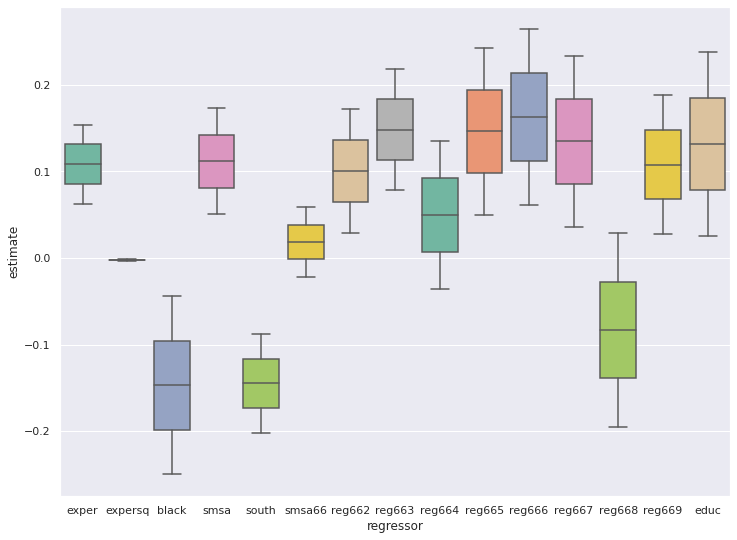

In [13]:
# Plot the upper and lower points using a boxplot

sns.boxplot(x="regressor", y="estimate", data=conf_int, palette="Set2")

# 3. Panel IV
---

In [14]:
# Import data from Acemoglu, Naidu, Restrepo and Robinson (2005), "Democracy Does Cause Growth"

demo_data = pd.read_csv("data/democracy-balanced-l4.csv", index_col=0).set_index(['country_name','year'])

# Include a year column
demo_data['year'] = demo_data.index.get_level_values('year').astype('str')

# Include a country column
demo_data['country'] = demo_data.index.get_level_values('country_name').astype('str')
demo_data

wbcode   id  dem      lgdp  year   country
country_name year                                           
Angola       1987    AGO    3  0.0  6.730205  1987    Angola
             1988    AGO    3  0.0  6.760224  1988    Angola
             1989    AGO    3  0.0  6.738738  1989    Angola
             1990    AGO    3  0.0  6.708020  1990    Angola
             1991    AGO    3  0.0  6.665598  1991    Angola
...                  ...  ...  ...       ...   ...       ...
Zimbabwe     2005    ZWE  202  0.0  5.893235  2005  Zimbabwe
             2006    ZWE  202  0.0  5.861276  2006  Zimbabwe
             2007    ZWE  202  0.0  5.827930  2007  Zimbabwe
             2008    ZWE  202  0.0  5.635891  2008  Zimbabwe
             2009    ZWE  202  0.0  5.692211  2009  Zimbabwe

[3381 rows x 6 columns]

In [15]:
# Drop rows with missing columns

demo_data = demo_data.dropna()
demo_data

wbcode   id  dem      lgdp  year   country
country_name year                                           
Angola       1987    AGO    3  0.0  6.730205  1987    Angola
             1988    AGO    3  0.0  6.760224  1988    Angola
             1989    AGO    3  0.0  6.738738  1989    Angola
             1990    AGO    3  0.0  6.708020  1990    Angola
             1991    AGO    3  0.0  6.665598  1991    Angola
...                  ...  ...  ...       ...   ...       ...
Zimbabwe     2005    ZWE  202  0.0  5.893235  2005  Zimbabwe
             2006    ZWE  202  0.0  5.861276  2006  Zimbabwe
             2007    ZWE  202  0.0  5.827930  2007  Zimbabwe
             2008    ZWE  202  0.0  5.635891  2008  Zimbabwe
             2009    ZWE  202  0.0  5.692211  2009  Zimbabwe

[3381 rows x 6 columns]

In [16]:
# Write function that returns original dataframe with additional lags for a specified col
# Patsy in Python does not have a lag operator to use in formulas

def get_lags(data, col, lag, level=0):
    for i in range(lag):
        data[f'{col}_{i+1}'] = data.groupby(level=level)[col].shift(i+1)
    return data.fillna(0)

In [17]:
get_lags(demo_data, 'lgdp', 99)

wbcode   id  dem      lgdp  year   country    lgdp_1  \
country_name year                                                        
Angola       1987    AGO    3  0.0  6.730205  1987    Angola  0.000000   
             1988    AGO    3  0.0  6.760224  1988    Angola  6.730205   
             1989    AGO    3  0.0  6.738738  1989    Angola  6.760224   
             1990    AGO    3  0.0  6.708020  1990    Angola  6.738738   
             1991    AGO    3  0.0  6.665598  1991    Angola  6.708020   
...                  ...  ...  ...       ...   ...       ...       ...   
Zimbabwe     2005    ZWE  202  0.0  5.893235  2005  Zimbabwe  5.949881   
             2006    ZWE  202  0.0  5.861276  2006  Zimbabwe  5.893235   
             2007    ZWE  202  0.0  5.827930  2007  Zimbabwe  5.861276   
             2008    ZWE  202  0.0  5.635891  2008  Zimbabwe  5.827930   
             2009    ZWE  202  0.0  5.692211  2009  Zimbabwe  5.635891   

                     lgdp_2    lgdp_3    lgdp_4  ...  lgdp_90  lgdp_91  \
country_name year                                ...                     
Angola       1987  0.000000  0.000000  0.000000  ...      0.0      0.0   
             1988  0.000000  0.000000  0.000000  ...      0.0      0.0   
             1989  6.730205  0.000000  0.000000  ...      0.0      0.0   
             1990  6.760224  6.730205  0.000000  ...      0.0      0.0   
             1991  6.738738  6.760224  6.730205  ...      0.0      0.0   
...                     ...       ...       ...  ...      ...      ...   
Zimbabwe     2005  6.008515  6.195195  6.290945  ...      0.0      0.0   
             2006  5.949881  6.008515  6.195195  ...      0.0      0.0   
             2007  5.893235  5.949881  6.008515  ...      0.0      0.0   
             2008  5.861276  5.893235  5.949881  ...      0.0      0.0   
             2009  5.827930  5.861276  5.893235  ...      0.0      0.0   

                   lgdp_92  lgdp_93  lgdp_94  lgdp_95  lgdp_96  lgdp_97  \
country_name year                                                         
Angola       1987      0.0      0.0      0.0      0.0      0.0      0.0   
             1988      0.0      0.0      0.0      0.0      0.0      0.0   
             1989      0.0      0.0      0.0      0.0      0.0      0.0   
             1990      0.0      0.0      0.0      0.0      0.0      0.0   
             1991      0.0      0.0      0.0      0.0      0.0      0.0   
...                    ...      ...      ...      ...      ...      ...   
Zimbabwe     2005      0.0      0.0      0.0      0.0      0.0      0.0   
             2006      0.0      0.0      0.0      0.0      0.0      0.0   
             2007      0.0      0.0      0.0      0.0      0.0      0.0   
             2008      0.0      0.0      0.0      0.0      0.0      0.0   
             2009      0.0      0.0      0.0      0.0      0.0      0.0   

                   lgdp_98  lgdp_99  
country_name year                    
Angola       1987      0.0      0.0  
             1988      0.0      0.0  
             1989      0.0      0.0  
             1990      0.0      0.0  
             1991      0.0      0.0  
...                    ...      ...  
Zimbabwe     2005      0.0      0.0  
             2006      0.0      0.0  
             2007      0.0      0.0  
             2008      0.0      0.0  
             2009      0.0      0.0  

[3381 rows x 105 columns]

In [31]:
get_lags(demo_data, 'dem', 99)

wbcode   id  dem      lgdp  year   country    lgdp_1  \
country_name year                                                        
Angola       1987    AGO    3  0.0  6.730205  1987    Angola  0.000000   
             1988    AGO    3  0.0  6.760224  1988    Angola  6.730205   
             1989    AGO    3  0.0  6.738738  1989    Angola  6.760224   
             1990    AGO    3  0.0  6.708020  1990    Angola  6.738738   
             1991    AGO    3  0.0  6.665598  1991    Angola  6.708020   
...                  ...  ...  ...       ...   ...       ...       ...   
Zimbabwe     2005    ZWE  202  0.0  5.893235  2005  Zimbabwe  5.949881   
             2006    ZWE  202  0.0  5.861276  2006  Zimbabwe  5.893235   
             2007    ZWE  202  0.0  5.827930  2007  Zimbabwe  5.861276   
             2008    ZWE  202  0.0  5.635891  2008  Zimbabwe  5.827930   
             2009    ZWE  202  0.0  5.692211  2009  Zimbabwe  5.635891   

                     lgdp_2    lgdp_3    lgdp_4  ...  dem_90  dem_91  dem_92  \
country_name year                                ...                           
Angola       1987  0.000000  0.000000  0.000000  ...     0.0     0.0     0.0   
             1988  0.000000  0.000000  0.000000  ...     0.0     0.0     0.0   
             1989  6.730205  0.000000  0.000000  ...     0.0     0.0     0.0   
             1990  6.760224  6.730205  0.000000  ...     0.0     0.0     0.0   
             1991  6.738738  6.760224  6.730205  ...     0.0     0.0     0.0   
...                     ...       ...       ...  ...     ...     ...     ...   
Zimbabwe     2005  6.008515  6.195195  6.290945  ...     0.0     0.0     0.0   
             2006  5.949881  6.008515  6.195195  ...     0.0     0.0     0.0   
             2007  5.893235  5.949881  6.008515  ...     0.0     0.0     0.0   
             2008  5.861276  5.893235  5.949881  ...     0.0     0.0     0.0   
             2009  5.827930  5.861276  5.893235  ...     0.0     0.0     0.0   

                   dem_93  dem_94  dem_95  dem_96  dem_97  dem_98  dem_99  
country_name year                                                          
Angola       1987     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
             1988     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
             1989     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
             1990     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
             1991     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
...                   ...     ...     ...     ...     ...     ...     ...  
Zimbabwe     2005     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
             2006     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
             2007     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
             2008     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
             2009     0.0     0.0     0.0     0.0     0.0     0.0     0.0  

[3381 rows x 204 columns]

In [34]:
demo_data = demo_data.fillna(0)

array([0., 1.])

## 1.1. Pooled OLS

In [24]:
# Naive OLS assuming i.i.d. data
# Remember! range(start, end) is an iterator for start, start + 1, ..., end - 1

lgdp_lags = '+'.join([f'lgdp_{i}' for i in range(1, 5)])
formula_OLS = f'lgdp ~ {lgdp_lags} + dem'
mod_OLS = PooledOLS.from_formula(formula_OLS, data=demo_data)
res_OLS = mod_OLS.fit(cov_type="clustered", cluster_entity=True)
res_OLS.summary

Dep. Variable:,lgdp,R-squared:,0.9602
Estimator:,PooledOLS,R-squared (Between):,0.9970
No. Observations:,3381,R-squared (Within):,-46.695
Date:,"Fri, Oct 02 2020",R-squared (Overall):,0.9602
Time:,17:37:31,Log-likelihood,-6271.3
Cov. Estimator:,Clustered,,
,,F-statistic:,1.628e+04
Entities:,147,P-value,0.0000
Avg Obs:,23.000,Distribution:,"F(5,3376)"
Min Obs:,23.000,,
Max Obs:,23.000,F-statistic (robust):,1.306e+05


## 3.2. Fixed Effects

In [25]:
# Two-way fixed effects

formula_fe = f'lgdp ~ {lgdp_lags} + dem + EntityEffects + TimeEffects'
mod_fe = PanelOLS.from_formula(formula_fe, data=demo_data)
res_fe = mod_fe.fit(cov_type="clustered", cluster_entity=True)
res_fe.summary

Dep. Variable:,lgdp,R-squared:,0.2680
Estimator:,PanelOLS,R-squared (Between):,0.4079
No. Observations:,3381,R-squared (Within):,-2.2356
Date:,"Fri, Oct 02 2020",R-squared (Overall):,0.4058
Time:,17:37:32,Log-likelihood,1621.0
Cov. Estimator:,Clustered,,
,,F-statistic:,234.78
Entities:,147,P-value,0.0000
Avg Obs:,23.000,Distribution:,"F(5,3207)"
Min Obs:,23.000,,
Max Obs:,23.000,F-statistic (robust):,7.5096


## 3.4. Anderson-Hsiao Panel IV 

In [26]:
# Anderson-Hsiao
# Following Rachel Meager's code, let's use 2-step efficient GMM to fit the A.H. model

formula_ah = f'lgdp ~ {lgdp_lags} + [dem ~ dem_1]'
mod_ah = IVGMM.from_formula(formula_ah, data=demo_data)
res_ah = mod_ah.fit()
res_ah.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-GMM Estimation Summary                           
==============================================================================
Dep. Variable:                   lgdp   R-squared:                      0.9582
Estimator:                     IV-GMM   Adj. R-squared:                 0.9582
No. Observations:                3381   F-statistic:                 9.922e+07
Date:                Fri, Oct 02 2020   P-value (F-stat)                0.0000
Time:                        17:37:34   Distribution:                  chi2(5)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
lgdp_1         1.0030     0.0006     1797.1     0.0000      1.0019      1.0041
lgdp_2        -0.0016     0.0008    -2.0950     0.0362     -0.0031     -0.0001
lgdp_3        -0.0015     0.0009    -1.6179     0.1057     -0.0033      0.0003
lgdp_4         0.0012     0.0007     1.6660     0.0957     -0.0002      0.0027
dem            0.0116     0.0028     4.1282     0.0000      0.0061      0.0171
==============================================================================

Endogenous: dem
Instruments: dem_1
GMM Covariance
Debiased: False
Robust (Heteroskedastic)
"""

## 3.5. Arellano-Bond Panel IV 

In [47]:
# Arellano-Bond
# Following Rachel Meager's code, let's use 2-step efficient GMM to fit the A.B. model

dem_lags = '+'.join([f'dem_{i}' for i in range(1, 23)])
formula_ab = f'lgdp ~ {lgdp_lags} + [dem ~ {dem_lags}]'
mod_ab = IVGMM.from_formula(formula_ab, data=demo_data.fillna(0))
res_ab = mod_ab.fit()
res_ab.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-GMM Estimation Summary                           
==============================================================================
Dep. Variable:                   lgdp   R-squared:                      0.9582
Estimator:                     IV-GMM   Adj. R-squared:                 0.9582
No. Observations:                3381   F-statistic:                   1.2e+08
Date:                Fri, Oct 02 2020   P-value (F-stat)                0.0000
Time:                        17:48:08   Distribution:                  chi2(5)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
lgdp_1         1.0029     0.0006     1807.9     0.0000      1.0018      1.0040
lgdp_2        -0.0016     0.0008    -2.1241     0.0337     -0.0031     -0.0001
lgdp_3        -0.0013     0.0009    -1.5017     0.1332     -0.0030      0.0004
lgdp_4         0.0014     0.0007     2.0767     0.0378   7.829e-05      0.0027
dem            0.0120     0.0027     4.3642     0.0000      0.0066      0.0174
==============================================================================

Endogenous: dem
Instruments: dem_1, dem_2, dem_3, dem_4, dem_5, dem_6, dem_7, dem_8, dem_9, dem_10, dem_11, dem_12, dem_13, dem_14, dem_15, dem_16, dem_17, dem_18, dem_19, dem_20, dem_21, dem_22
GMM Covariance
Debiased: False
Robust (Heteroskedastic)
"""

In [48]:
# Note: it seems including 23 or more lags makes the matrix singular

dem_lags = '+'.join([f'dem_{i}' for i in range(1, 24)])
formula_ab = f'lgdp ~ {lgdp_lags} + [dem ~ {dem_lags}]'
mod_ab = IVGMM.from_formula(formula_ab, data=demo_data.fillna(0))
res_ab = mod_ab.fit()
res_ab.summary

ValueError: instruments [exog instruments]  do not have full column rank